<a href="https://colab.research.google.com/github/JoshDumo/histopathology/blob/main/Onco_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Colorectal histopathology**
## Classification of textures

This notebook uses 

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.4.1


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteABVW0I/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Label: 7


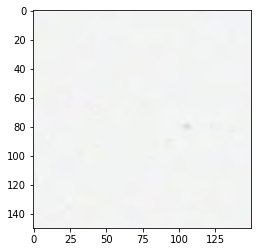

In [2]:
# EXTRACT

test_ds = tfds.load(name="colorectal_histology", 
                   split="train[0%:10%]",
                   shuffle_files=True,
                   as_supervised=True)

val_ds = tfds.load(name="colorectal_histology", 
                   split="train[10%:30%]",
                   shuffle_files=True,
                   as_supervised=True)

train_ds = tfds.load(name="colorectal_histology", 
                     split="train[-70%:]", 
                     shuffle_files=True, 
                     as_supervised=True)

# TRANSFORM
#train_ds.shuffle(100).batch(32).prefetch(tf.data.AUTOTUNE)

# LOAD
for data in train_ds.take(1):
    image = data[0].numpy().squeeze()
    label = data[1].numpy()
    
    print("Label: {}".format(label))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()


In [3]:
tester = test_ds.take(1)
img_1 = []
lab_1 = 0
for example in tester:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  img_1 = example[0]
  lab_1 = example[1]
  #print(img_1.shape)
img_1.shape
lab_1

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


In [5]:
tds = train_ds.as_numpy_iterator()
labs = []
for el in tds:
  labs.append(el[1])

lab_cnt = []
for i in range(0,8):
  lab_cnt.append(labs.count(i))
lab_cnt
lab_list = ['Tumor', 'Stroma','Complex', 'Lympho','Debris','Mucosa','Adipose','Empty']

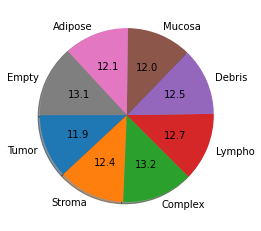

<Figure size 1152x1152 with 0 Axes>

In [6]:
plt.pie(lab_cnt, labels=['Tumor', 'Stroma','Complex', 'Lympho','Debris','Mucosa','Adipose','Empty'], startangle=180, 
        autopct='%1.1f', shadow=True)
plt.figure(figsize=(16,16))
plt.show()

In [7]:
test_lb = test_ds.as_numpy_iterator()
test_labels = []
for tlb in test_lb:
  test_labels.append(tlb[1])

In [8]:
train_ds = train_ds.map(normalize_img,
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

In [9]:
val_ds = val_ds.map(normalize_img,
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(128).cache().prefetch(tf.data.AUTOTUNE)

In [10]:
test_ds = test_ds.map(normalize_img,
                    num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(128).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
val_ds.enumerate()

<ZipDataset shapes: ((), ((None, 150, 150, 3), (None,))), types: (tf.int64, (tf.float32, tf.int64))>

### Model
We design a simple 2D Convolutional Neural Network to classify the textures. The 

In [59]:
kernel_size = (3,3)
pool_size= (2,2)

## Model 3
#zeroth_filters = 16
#first_filters = 64
#second_filters = 256
#third_filters = 1024

## Model 4
zeroth_filters = 16
first_filters = 64
second_filters = 128
third_filters = 256

dropout_conv = 0.3
dropout_dense = 0.3


model = tf.keras.models.Sequential([
                                    layers.Conv2D(zeroth_filters, kernel_size, padding='same',activation = 'relu', input_shape = (150, 150, 3)),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    layers.Conv2D(first_filters, kernel_size, activation = 'relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    layers.Conv2D(second_filters, kernel_size, activation ='relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    layers.Conv2D(third_filters, kernel_size, activation ='relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    
                                    layers.Flatten(),
                                    layers.Dense(256, activation = "relu"),
                                    layers.Dense(8, activation = "softmax")
                                    
])


model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 73, 73, 64)        9280      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 15, 15, 256)      

In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [61]:
filepath = "model4.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=40, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/40
28/28 [==============================] - 4s 98ms/step - loss: 1.7580 - sparse_categorical_accuracy: 0.2820 - val_loss: 1.1071 - val_sparse_categorical_accuracy: 0.5200

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.52000, saving model to model4.h5
Epoch 2/40
28/28 [==============================] - 2s 82ms/step - loss: 1.0097 - sparse_categorical_accuracy: 0.5643 - val_loss: 0.8108 - val_sparse_categorical_accuracy: 0.6890

Epoch 00002: val_sparse_categorical_accuracy improved from 0.52000 to 0.68900, saving model to model4.h5
Epoch 3/40
28/28 [==============================] - 2s 81ms/step - loss: 0.7923 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.8557 - val_sparse_categorical_accuracy: 0.6090

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.68900
Epoch 4/40
28/28 [==============================] - 2s 82ms/step - loss: 0.7317 - sparse_categorical_accuracy: 0.6891 - val_loss: 0.7180 - val_sparse_categorical_accuracy: 0.7050


In [62]:
val_loss, val_acc = model.evaluate(test_ds)

4/4 [==============================] - 0s 93ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8500


In [63]:
val_loss, val_acc

(0.48250946402549744, 0.8500000238418579)

<Figure size 432x288 with 0 Axes>

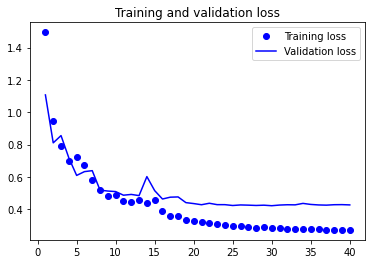

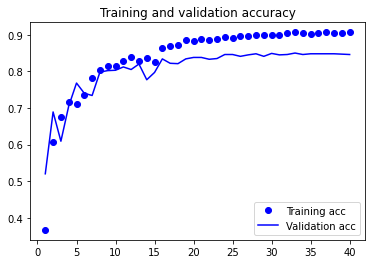

<Figure size 432x288 with 0 Axes>

In [64]:

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


In [65]:
predictions = model.predict(test_ds)

In [66]:
predictions.shape

(500, 8)

In [67]:
preds_ds = pd.DataFrame(predictions, columns=lab_list)
preds_ds.head()

,Tumor,Stroma,Complex,Lympho,Debris,Mucosa,Adipose,Empty
0,0.005682,3.730897e-02,6.872191e-02,1.098993e-03,1.806667e-02,0.869121,1.045401e-07,1.720593e-22
1,0.000117,4.077539e-01,1.790478e-03,1.028707e-06,5.903228e-01,0.000001,1.410352e-05,4.690146e-08
2,0.999988,1.512334e-15,9.641783e-06,1.029691e-07,1.681013e-09,0.000002,4.158833e-17,8.041186e-35
3,0.962698,8.228130e-11,1.030561e-03,6.120521e-03,9.940077e-06,0.030141,2.844341e-15,1.209026e-33
4,0.000001,8.011947e-06,4.840205e-08,2.739878e-11,1.642254e-03,0.000001,9.810021e-01,1.734531e-02


In [68]:
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

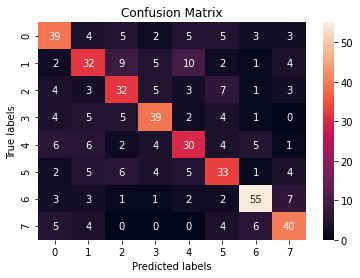

In [69]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [70]:
import pathlib
import PIL

#im_2 = PIL.Image.open("/content/10C74_CRC-Prim-HE-03.tif_Row_1651_Col_601.tif")
im_3 = tf.keras.preprocessing.image.load_img("/content/01Tumor.tif")
im_3 = tf.keras.preprocessing.image.img_to_array(im_3)
im_3 = tf.cast(im_3, tf.float32) / 255.

In [71]:
baseline_im = tf.ones(shape=(150,150,3))


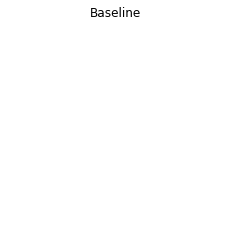

In [72]:
plt.imshow(baseline_im)
plt.title("Baseline")
plt.axis('off')
plt.show()


In [73]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.


In [75]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [76]:
interpolated_images = interpolate_images(
    baseline=baseline_im,
    image=im_3,
    alphas=alphas)


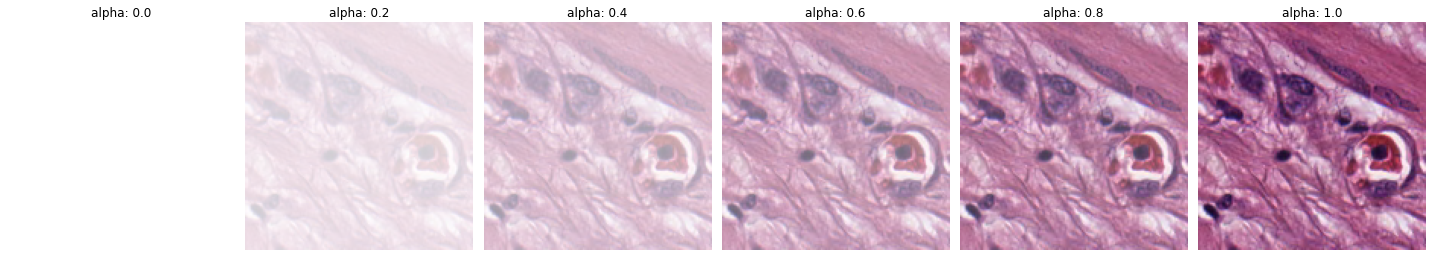

In [77]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();


In [78]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)


In [79]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=0)


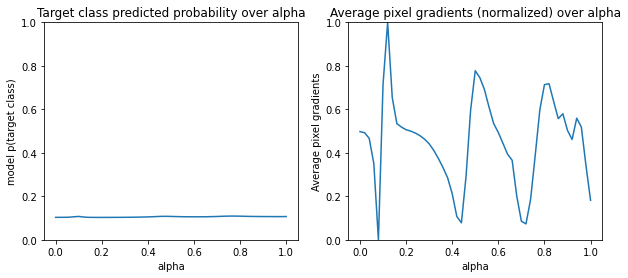

In [80]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);


In [81]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients


In [82]:
ig = integral_approximation(
    gradients=path_gradients)


In [83]:
print(ig.shape)


(150, 150, 3)


In [84]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients


In [85]:
ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_3,
                                       target_class_idx=0,
                                       m_steps=480)


In [86]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig


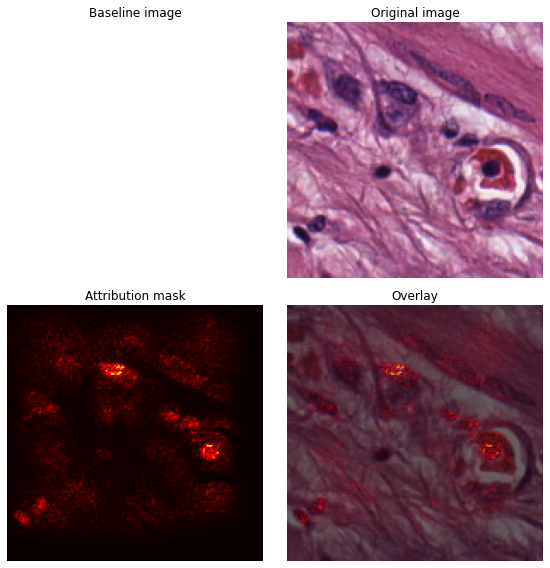

In [87]:
_ = plot_img_attributions(image=im_3,
                          baseline=baseline_im,
                          target_class_idx=0,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.4)


In [88]:
im_B = tf.keras.preprocessing.image.load_img("/content/02Stroma.tif")
im_B = tf.keras.preprocessing.image.img_to_array(im_B)
im_B = tf.cast(im_B, tf.float32) / 255.

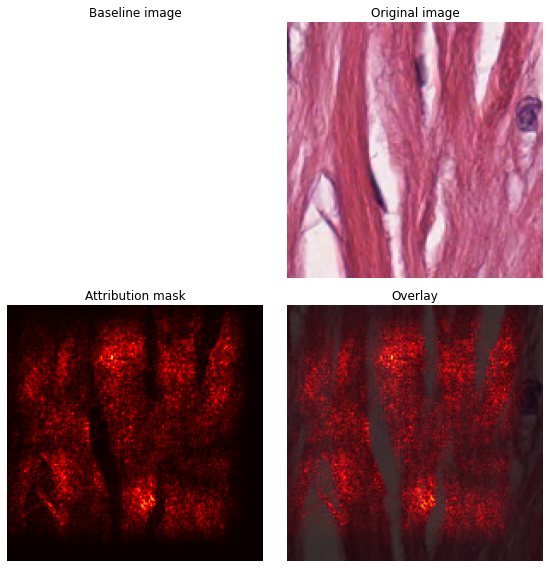

In [89]:
ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_B,
                                       target_class_idx=1,
                                       m_steps=480)
_ = plot_img_attributions(image=im_B,
                          baseline=baseline_im,
                          target_class_idx=1,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.2)


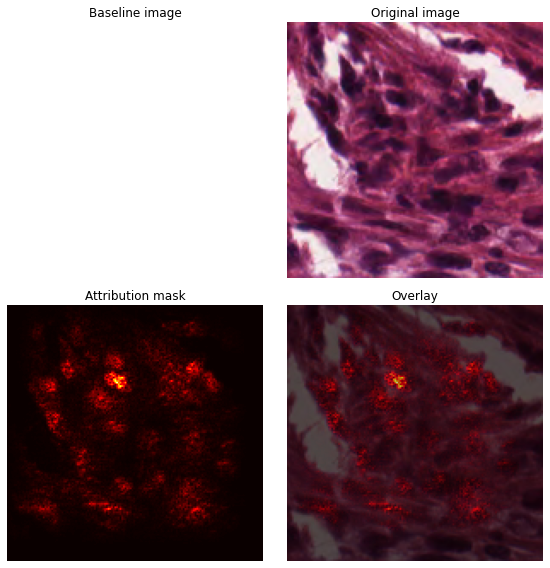

In [90]:
im_C = tf.keras.preprocessing.image.load_img("/content/03Complex.tif")
im_C = tf.keras.preprocessing.image.img_to_array(im_C)
im_C = tf.cast(im_C, tf.float32) / 255.

ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_C,
                                       target_class_idx=2,
                                       m_steps=480)
_ = plot_img_attributions(image=im_C,
                          baseline=baseline_im,
                          target_class_idx=2,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.3)




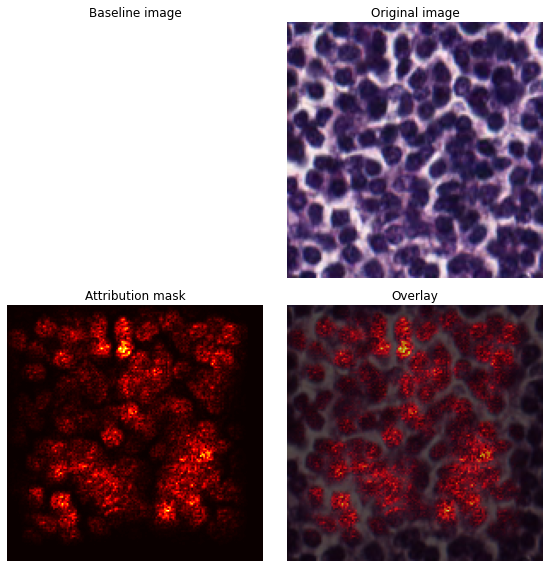

In [91]:
im_D = tf.keras.preprocessing.image.load_img("/content/04Lympho.tif")
im_D = tf.keras.preprocessing.image.img_to_array(im_D)
im_D = tf.cast(im_D, tf.float32) / 255.

ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_D,
                                       target_class_idx=3,
                                       m_steps=480)
_ = plot_img_attributions(image=im_D,
                          baseline=baseline_im,
                          target_class_idx=3,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.3)

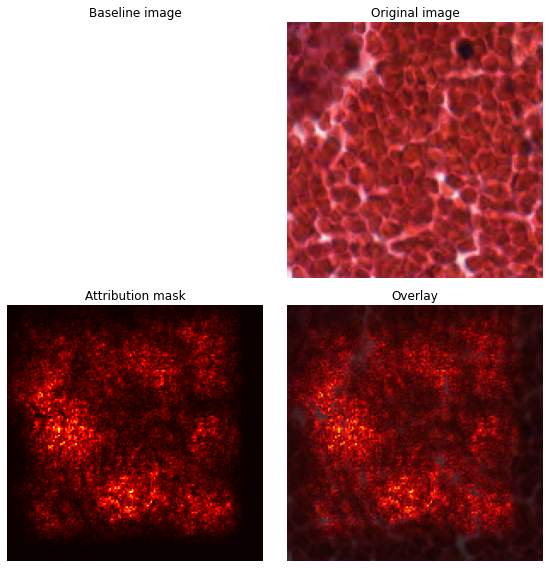

In [92]:
im_E = tf.keras.preprocessing.image.load_img("/content/05Debris.tif")
im_E = tf.keras.preprocessing.image.img_to_array(im_E)
im_E = tf.cast(im_E, tf.float32) / 255.

ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_E,
                                       target_class_idx=4,
                                       m_steps=480)
_ = plot_img_attributions(image=im_E,
                          baseline=baseline_im,
                          target_class_idx=4,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.2)

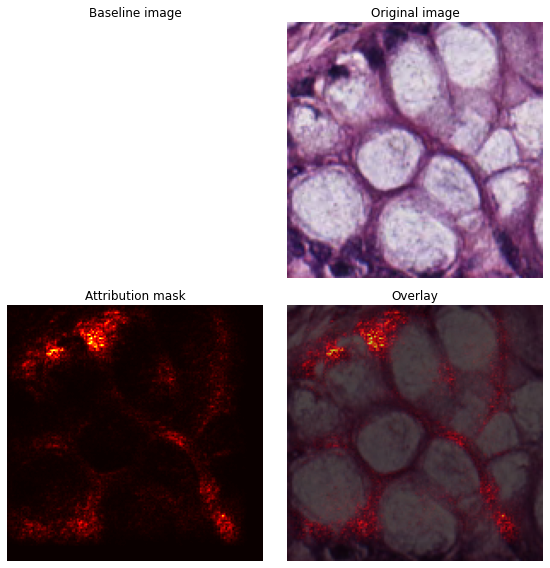

In [93]:
im_F = tf.keras.preprocessing.image.load_img("/content/06Mucosa.tif")
im_F = tf.keras.preprocessing.image.img_to_array(im_F)
im_F = tf.cast(im_F, tf.float32) / 255.

ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_F,
                                       target_class_idx=5,
                                       m_steps=480)
_ = plot_img_attributions(image=im_F,
                          baseline=baseline_im,
                          target_class_idx=5,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.3)

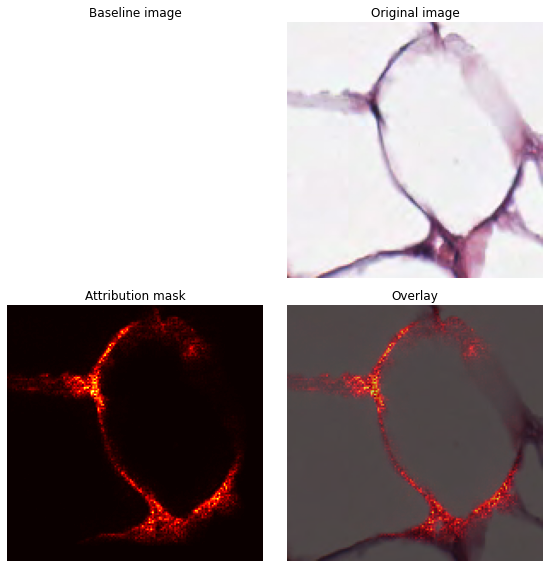

In [94]:
im_G = tf.keras.preprocessing.image.load_img("/content/07Adipose.tif")
im_G = tf.keras.preprocessing.image.img_to_array(im_G)
im_G = tf.cast(im_G, tf.float32) / 255.

ig_attributions = integrated_gradients(baseline=baseline_im,
                                       image=im_G,
                                       target_class_idx=6,
                                       m_steps=480)
_ = plot_img_attributions(image=im_G,
                          baseline=baseline_im,
                          target_class_idx=6,
                          m_steps=480,
                          cmap=plt.cm.hot,
                          overlay_alpha=0.3)

In this way

### **References**
Kather, J. N., Zöllner, F. G., Bianconi, F., Melchers, S. M., Schad, L. R., Gaiser, T., Weis, C.-A. (2016). Collection of textures in colorectal cancer histology [Data set]. Zenodo. http://doi.org/10.5281/zenodo.53169